In [4]:
documents = []

file = open('Tratando Arquivos/docs.txt', 'r')
for line in file:
    documents.append(line)
file.close()

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000 # max number of uniq words

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [6]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 20
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                            for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(message)
    print()

In [8]:
no_top_words = 5
display_topics(lda, tf_feature_names, no_top_words)

Topic #0: bad lost little help things
Topic #1: today wanna sucks day sun
Topic #2: want long yeah pretty hurt
Topic #3: sad know right dont trying
Topic #4: im wish make soon missed
Topic #5: fun damn bored start sure
Topic #6: home amp tired cold old
Topic #7: love new tonight left phone
Topic #8: night feeling looking gotta say
Topic #9: twitter week working watch hurts
Topic #10: work like bed gonna hope
Topic #11: quot come days poor coming
Topic #12: going sleep miss tomorrow work
Topic #13: http com haha twitpic waiting
Topic #14: time oh man hard happy
Topic #15: day good really school nice
Topic #16: morning great clean watching missing
Topic #17: feel hate getting way people
Topic #18: got need think better hours
Topic #19: lol sorry friends big wow



In [9]:
import pandas as pd
import numpy as np
   
# Create Document - Topic Matrix
lda_output = lda.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(no_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(documents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
   color = 'green' if val > .1 else 'black'
   return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.01,0.01,0.01,0.01,0.01,0.26,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.38,0.01,0.13,0.01,0.01,0.13,0.01,13
Doc1,0.01,0.15,0.01,0.01,0.01,0.15,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.58,0.01,0.01,0.01,0.01,15
Doc2,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.61,0.01,0.01,0.01,0.01,0.01,0.01,0.21,0.01,11
Doc3,0.01,0.01,0.01,0.01,0.01,0.51,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.26,0.01,0.01,0.01,5
Doc4,0.03,0.03,0.52,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
Doc5,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0
Doc6,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.68,0.02,18
Doc7,0.01,0.01,0.1,0.51,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.11,0.01,0.1,0.01,0.01,0.11,3
Doc8,0.52,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0
Doc9,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0


In [10]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,5447
1,1,4848
2,3,4847
3,2,3616
4,12,3356
5,4,3162
6,10,3061
7,6,2593
8,8,2213
9,7,2190


In [11]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

c:\users\pc-dell\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster      Freq
topic                                                 
12      4.704743 -50.989075       1        1  7.276088
10     60.282349   1.936413       2        1  6.857655
15     27.241137 -78.308723       3        1  6.241415
3       0.824687  34.692326       4        1  6.104881
1      65.837036  31.788649       5        1  5.340231
17     -8.418518 -78.477982       6        1  5.289385
4      32.611599  16.910749       7        1  4.950096
6     -43.091503 -15.364854       8        1  4.930195
18    -28.059044 -48.178349       9        1  4.923962
16      7.455401   3.113314      10        1  4.902681
8      88.679413  -8.027534      11        1  4.883820
7     -23.890467  13.594459      12        1  4.703254
13     59.196636 -67.137505      13        1  4.594713
2      14.067065 -25.638802      14        1  4.530805
9     -12.550884 -19.358976      15        1  4.455907
19     32.226974  47.455559      16        1  4.308249
14     84.734024 -44.183910      17        1  4.244549
11     35.720375 -11.863084      18        1  4.067937
0      57.987907 -29.490730      19        1  3.879725
5      34.845570 -46.385723      20        1  3.514453, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
860   Default  2487.000000      today  2487.000000  30.0000  30.0000
970   Default  3308.000000       work  3308.000000  29.0000  29.0000
379   Default  2119.000000        got  2119.000000  28.0000  28.0000
208   Default  2577.000000        day  2577.000000  27.0000  27.0000
856   Default  1849.000000       time  1849.000000  26.0000  26.0000
927   Default  1872.000000       want  1872.000000  25.0000  25.0000
460   Default  1795.000000         im  1795.000000  24.0000  24.0000
687   Default  1680.000000       quot  1680.000000  23.0000  23.0000
370   Default  2013.000000      going  2013.000000  22.0000  22.0000
373   Default  1830.000000       good  1830.000000  21.0000  21.0000
701   Default  1764.000000     really  1764.000000  20.0000  20.0000
512   Default  2362.000000       like  2362.000000  19.0000  19.0000
626   Default  1410.000000         oh  1410.000000  18.0000  18.0000
618   Default  1447.000000      night  1447.000000  17.0000  17.0000
433   Default  1439.000000       home  1439.000000  16.0000  16.0000
446   Default  1368.000000       http  1368.000000  15.0000  15.0000
75    Default  1296.000000        bad  1296.000000  14.0000  14.0000
610   Default  1398.000000       need  1398.000000  13.0000  13.0000
524   Default  1297.000000        lol  1297.000000  12.0000  12.0000
960   Default  1346.000000       wish  1346.000000  11.0000  11.0000
845   Default  1324.000000      think  1324.000000  10.0000  10.0000
720   Default  1387.000000        sad  1387.000000   9.0000   9.0000
769   Default  1438.000000      sleep  1438.000000   8.0000   8.0000
490   Default  1346.000000       know  1346.000000   7.0000   7.0000
595   Default  1240.000000    morning  1240.000000   6.0000   6.0000
44    Default  1225.000000        amp  1225.000000   5.0000   5.0000
582   Default  1344.000000       miss  1344.000000   4.0000   4.0000
732   Default  1258.000000     school  1258.000000   3.0000   3.0000
300   Default  1177.000000       feel  1177.000000   2.0000   2.0000
170   Default  1119.000000        com  1119.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
201   Topic20   622.546564       damn   623.495967   3.3468  -2.4507
108   Topic20   583.585103      bored   584.534507   3.3467  -2.5153
797   Topic20   410.112455      start   411.061858   3.3460  -2.8680
825   Topic20   374.670674       sure   375.620078   3.3458  -2.9584
805   Topic20   324.480199       stop   325.429603   3.3454  -3.1022
303   Topic20   258.153687      feels   259.103090   3.3446  -3.3309
235   Topic20   230.356249        don   231.305653   3.3

Text(0.5,1,'Segregation of Topic Clusters')

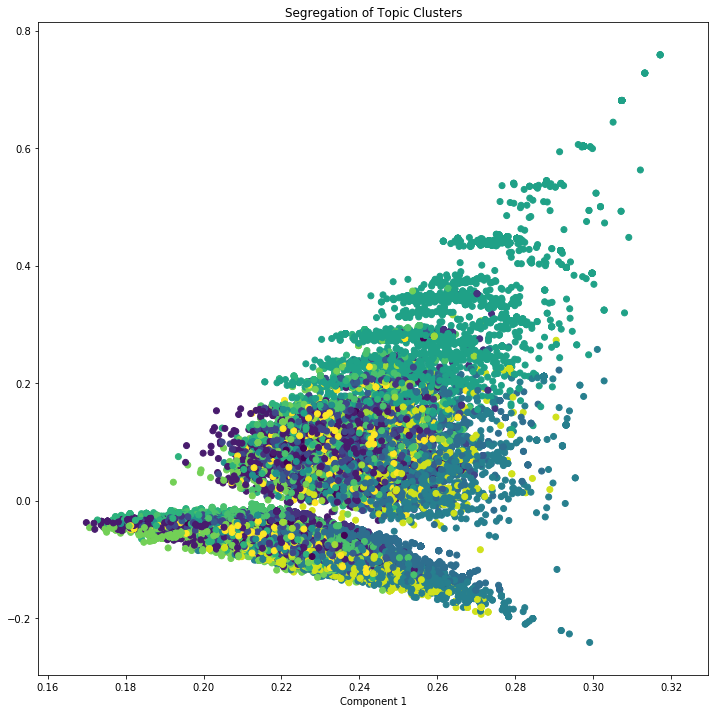

In [12]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

,00,10,100,11,12,14,15,17,18,1st,...,yay,yea,yeah,year,years,yep,yes,yesterday,yo,youtube
Topic0,0.05,0.05,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05000,0.050000,0.05,0.050000,0.050000,0.05,0.050000,0.05
Topic1,0.05,0.05,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05000,327.712197,0.05,0.050000,0.050000,0.05,0.050000,0.05
Topic2,0.05,0.05,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,562.55885,0.050000,0.05,67.089793,0.050000,0.05,0.050000,0.05
Topic3,0.05,0.05,0.05,0.050000,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05000,0.050000,0.05,0.050000,360.085178,0.05,54.982387,0.05
Topic4,0.05,0.05,0.05,110.445615,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05000,0.050000,0.05,0.050000,0.050000,0.05,0.050000,0.05
